In [1]:
import os
import pandas as pd

In [2]:
#import autti labels to dataframe

annotation_root = os.path.join("annotations", "object-dataset")
annotation_path = os.path.join(annotation_root, "labels.csv")

df = pd.read_csv(annotation_path, sep = " ", header = None, names = ["frame", "xmin", "ymin", "xmax", "ymax", "occluded", "label","attributes"])

df.head()

,frame,xmin,ymin,xmax,ymax,occluded,label,attributes
0,1478019952686311006.jpg,950,574,1004,620,0,car,NaN
1,1478019952686311006.jpg,1748,482,1818,744,0,pedestrian,NaN
2,1478019953180167674.jpg,872,586,926,632,0,car,NaN
3,1478019953689774621.jpg,686,566,728,618,1,truck,NaN
4,1478019953689774621.jpg,716,578,764,622,0,car,NaN


In [3]:
#only take car labels
cardf = df[ df.label == 'car']

cardf = cardf.drop(['label', 'attributes'], 1)

cardf.head()

,frame,xmin,ymin,xmax,ymax,occluded
0,1478019952686311006.jpg,950,574,1004,620,0
2,1478019953180167674.jpg,872,586,926,632,0
4,1478019953689774621.jpg,716,578,764,622,0
5,1478019953689774621.jpg,826,580,880,626,0
6,1478019953689774621.jpg,1540,488,1680,608,1


In [4]:
#group by frames and convert object detections to list
cardfg = cardf.groupby(['frame'], as_index = False)

cardfl = cardfg.aggregate( lambda x : list(x) )

cardfl.head()

,frame,xmin,ymin,xmax,ymax,occluded
0,1478019952686311006.jpg,[950],[574],[1004],[620],[0]
1,1478019953180167674.jpg,[872],[586],[926],[632],[0]
2,1478019953689774621.jpg,"[716, 826, 1540, 1646]","[578, 580, 488, 498]","[764, 880, 1680, 1848]","[622, 626, 608, 594]","[0, 0, 1, 1]"
3,1478019954186238236.jpg,"[686, 802, 1448, 1732]","[576, 582, 474, 498]","[730, 856, 1722, 1918]","[628, 628, 596, 594]","[0, 0, 1, 1]"
4,1478019954685370994.jpg,"[662, 776, 1492]","[576, 578, 472]","[708, 830, 1830]","[624, 624, 608]","[0, 0, 1]"


In [5]:
# Add relative path to files
cardfl.reset_index()
cardfl['frame'] = cardfl['frame'].apply(lambda x: os.path.join(annotation_root, x))
cardfl.head()

,frame,xmin,ymin,xmax,ymax,occluded
0,annotations/object-dataset/1478019952686311006...,[950],[574],[1004],[620],[0]
1,annotations/object-dataset/1478019953180167674...,[872],[586],[926],[632],[0]
2,annotations/object-dataset/1478019953689774621...,"[716, 826, 1540, 1646]","[578, 580, 488, 498]","[764, 880, 1680, 1848]","[622, 626, 608, 594]","[0, 0, 1, 1]"
3,annotations/object-dataset/1478019954186238236...,"[686, 802, 1448, 1732]","[576, 582, 474, 498]","[730, 856, 1722, 1918]","[628, 628, 596, 594]","[0, 0, 1, 1]"
4,annotations/object-dataset/1478019954685370994...,"[662, 776, 1492]","[576, 578, 472]","[708, 830, 1830]","[624, 624, 608]","[0, 0, 1]"


In [44]:
import tensorflow as tf
from object_detection.utils import dataset_util
import hashlib
import io
import PIL.Image

def create_tf_example(df_row):
  #Populate the following variables from your example.
  filename = df_row['frame']
  
  with tf.gfile.GFile(filename, 'rb') as fid:
    encoded_jpg = fid.read()
  
  encoded_image_data = io.BytesIO(encoded_jpg) # Encoded image bytes
  image = PIL.Image.open(encoded_image_data)
  if image.format != 'JPEG':
    raise ValueError('Image format not JPEG')
  key = hashlib.sha256(encoded_jpg).hexdigest()

  height = 1200 # Image height
  width = 1920 # Image width
  
  image_format = b'jpeg'

  xmins = [max(x / width, 0) for x in df_row['xmin'] ] # List of normalized left x coordinates in bounding box (1 per box)
  xmaxs = [min(x / width, 1) for x in df_row['xmax'] ] # List of normalized right x coordinates in bounding box
             # (1 per box)
  ymins = [max(y / height, 0) for y in df_row['ymin'] ] # List of normalized top y coordinates in bounding box (1 per box)
  ymaxs = [min(y / height, 1) for y in df_row['ymax'] ] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
  classes_text = ["car".encode('utf8')] * len(xmins) # List of string class name of bounding box (1 per box)
  classes = [1] * len(xmins) # List of integer class id of bounding box (1 per box)
    
  fnamebytes = filename.encode()

  tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(fnamebytes),
      'image/source_id': dataset_util.bytes_feature(fnamebytes),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))
  return tf_example


In [45]:
#read some images and display them
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
cardfl.iloc[2]['frame']

'annotations/object-dataset/1478019953689774621.jpg'

(1200, 1920, 3)


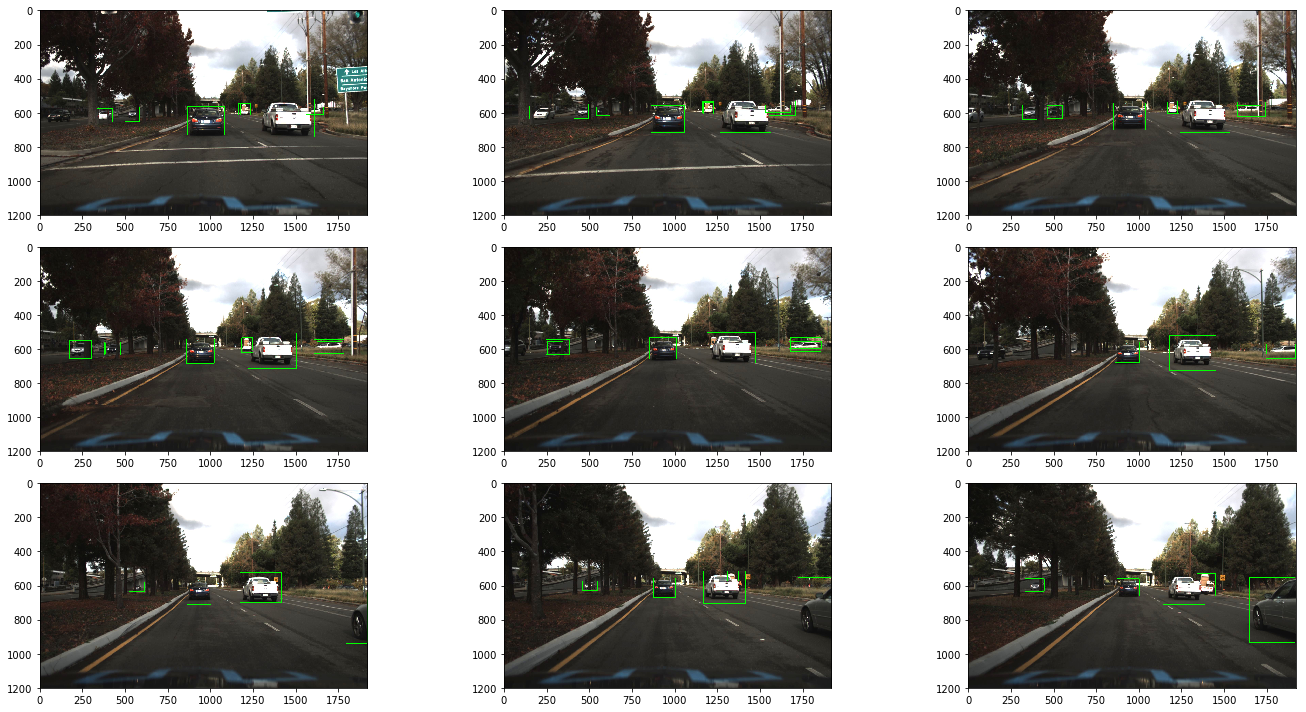

In [46]:
import cv2
f, axs = plt.subplots(3, 3, figsize = (20, 10))
for ii in range(3):
    for jj in range(3):
        inx = ii * 3 + jj + 1000
        filename = cardfl.iloc[inx]['frame']
        xmin = cardfl.iloc[inx]['xmin']
        ymin = cardfl.iloc[inx]['ymin']
        xmax = cardfl.iloc[inx]['xmax']
        ymax = cardfl.iloc[inx]['ymax']
        img = mpimg.imread(filename)
        for xm,ym,xma,yma in zip(xmin, ymin,xmax,ymax):
            cv2.rectangle(img, (xm, ym), (xma,yma), color = (0,255,0), thickness = 2)
        if ii == 0 and jj == 0:
            print(img.shape)
        axs[ii, jj].imshow(img)
plt.tight_layout()

### Write records 

In [47]:
#do the same for the crowdai dataset
annotation_path = "labels_crowdai.csv"

df = pd.read_csv(annotation_path, sep = ",")

print(df.columns)
df = df.drop(df.columns[ [-1] ], axis = 1)
df.head()

Index(['xmin', 'ymin', 'xmax', 'ymax', 'Frame', 'Label', 'Preview URL'], dtype='object')


,xmin,ymin,xmax,ymax,Frame,Label
0,785,533,905,644,1479498371963069978.jpg,Car
1,89,551,291,680,1479498371963069978.jpg,Car
2,268,546,383,650,1479498371963069978.jpg,Car
3,455,522,548,615,1479498371963069978.jpg,Truck
4,548,522,625,605,1479498371963069978.jpg,Truck


In [48]:
#reorder columns
df = df[['Frame','xmin', 'ymin','xmax','ymax','Label']]
df.rename(columns={'Frame': 'frame', 'Label': 'label'}, inplace=True)
df.head()

,frame,xmin,ymin,xmax,ymax,label
0,1479498371963069978.jpg,785,533,905,644,Car
1,1479498371963069978.jpg,89,551,291,680,Car
2,1479498371963069978.jpg,268,546,383,650,Car
3,1479498371963069978.jpg,455,522,548,615,Truck
4,1479498371963069978.jpg,548,522,625,605,Truck


In [49]:
#group by frames and convert object detections to list
cardfg_1 = df.groupby(['frame'], as_index = False)

cardfl_1 = cardfg_1.aggregate( lambda x : list(x) )

# Add relative path to files
cardfl_1.reset_index()
cardfl_1['frame'] = cardfl_1['frame'].apply(lambda x: os.path.join("annotations", "object-detection-crowdai", x))
cardfl_1.head()

,frame,xmin,ymin,xmax,ymax,label
0,annotations/object-detection-crowdai/147949837...,"[785, 89, 268, 455, 548, 1726, 758, 633, 682]","[533, 551, 546, 522, 522, 484, 557, 561, 557]","[905, 291, 383, 548, 625, 1919, 807, 680, 718]","[644, 680, 650, 615, 605, 646, 617, 597, 593]","[Car, Car, Car, Truck, Truck, Car, Car, Car, Car]"
1,annotations/object-detection-crowdai/147949837...,"[710, 0, 139, 368, 472, 562, 1769, 684, 613]","[540, 550, 548, 528, 528, 569, 530, 570, 561]","[836, 149, 270, 468, 550, 614, 1918, 723, 651]","[665, 689, 661, 624, 611, 609, 683, 628, 599]","[Car, Car, Car, Truck, Truck, Car, Car, Car, Car]"
2,annotations/object-detection-crowdai/147949837...,"[0, 109, 343, 450, 550, 600, 684, 1778]","[554, 559, 533, 532, 582, 580, 546, 553]","[112, 241, 448, 531, 595, 637, 820, 1919]","[698, 676, 634, 622, 607, 603, 671, 693]","[Car, Car, Truck, Truck, Car, Car, Car, Car]"
3,annotations/object-detection-crowdai/147949837...,"[417, 306, 655, 60, 0, 523, 573, 1762]","[534, 544, 557, 565, 561, 582, 586, 546]","[509, 421, 790, 211, 63, 571, 613, 1920]","[640, 653, 698, 692, 711, 632, 617, 728]","[Truck, Truck, Car, Car, Car, Car, Car, Car]"
4,annotations/object-detection-crowdai/147949837...,"[1558, 404, 47, 170, 287, 338]","[530, 577, 563, 563, 614, 609]","[1919, 547, 165, 261, 335, 379]","[749, 710, 666, 657, 643, 640]","[Car, Car, Truck, Truck, Car, Car]"


(1200, 1920, 3)


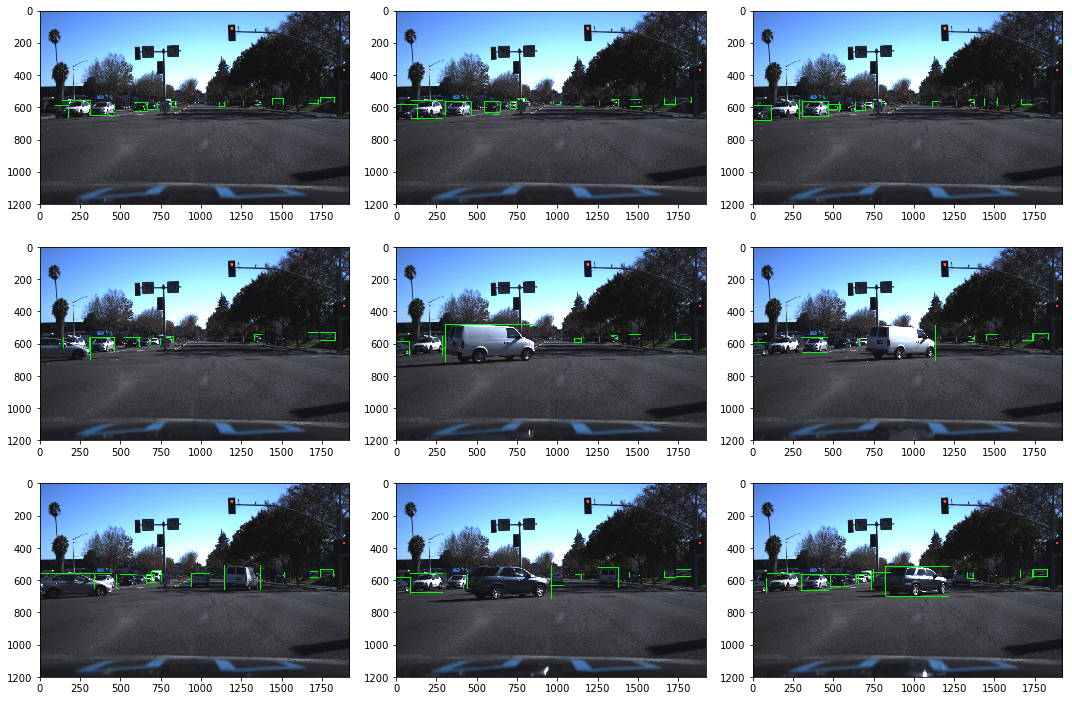

In [50]:
#visualize dataset
f, axs = plt.subplots(3, 3, figsize = (15, 10))
for ii in range(3):
    for jj in range(3):
        inx = ii * 3 + jj + 100
        filename = cardfl_1.iloc[inx]['frame']
        xmin = cardfl_1.iloc[inx]['xmin']
        ymin = cardfl_1.iloc[inx]['ymin']
        xmax = cardfl_1.iloc[inx]['xmax']
        ymax = cardfl_1.iloc[inx]['ymax']
        img = mpimg.imread(filename)
        for xm,ym,xma,yma in zip(xmin, ymin,xmax,ymax):
            cv2.rectangle(img, (xm, ym), (xma,yma), color = (0,255,0), thickness = 2)
        if ii == 0 and jj == 0:
            print(img.shape)
        axs[ii, jj].imshow(img)
plt.tight_layout()

In [51]:
from sklearn.model_selection import train_test_split

def write_records(output_path, df):
  writer = tf.python_io.TFRecordWriter(output_path)

  for _ , row in df.iterrows():
    tf_example = create_tf_example(row)
    writer.write(tf_example.SerializeToString())

  writer.close()

#combine both datasets
car_df_combined = pd.concat( [cardfl, cardfl_1] )

#split dataset into training and test sets
train, test = train_test_split(cardfl, test_size = 0.2)

#write records

write_records('objdetdata/train.record', train)
write_records('objdetdata/test.record', test)